# RSSI Data Prediction using Random Forest

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Reshape
from tensorflow.keras.callbacks import EarlyStopping

#### Reading csv files to Dataframes

In [3]:
def load_data(file_paths):
    all_data = []
    for path in file_paths:
        df = pd.read_csv(path)
    return df
    
file_paths = ['rssi_data_PB.csv', 'rssi_data_stbkscc.csv', 'rssi_data_ccl.csv', 'rssi_data_roastd.csv'] 
df = load_data(file_paths)
print(df.head())


             timestamp         ssid               bssid  rssi  crowd_count
0  2024-11-09 11:11:36    Roastd-JC  38:3f:b3:45:d8:a0:   -49           20
1  2024-11-09 11:11:36  newportwifi  82:8a:20:25:91:ec:   -92           20
2  2024-11-09 11:11:36  newportwifi  82:8a:20:25:94:12:   -72           20
3  2024-11-09 11:11:36  newportwifi  7e:8a:20:24:91:ec:   -68           20
4  2024-11-09 11:11:36  newportwifi  7e:8a:20:24:94:12:   -59           20


In [4]:
# converting timestamp to a numerical feature
df['timestamp'] = pd.to_datetime(df['timestamp']).astype('int64') // 10**9

# encoding categorical features
df = pd.get_dummies(df, columns=['ssid', 'bssid'], drop_first=True)

In [5]:
X = df.drop('crowd_count', axis=1)
y = df['crowd_count']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# predicting on test data
y_pred = rf_model.predict(X_test)

In [20]:
rf_mse = mean_squared_error(y_test, y_pred)
rf_mae = mean_absolute_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)

print(f'Mean Squared Error: {rf_mse:.2f}')
print(f"Mean Absolute Error (MAE): {rf_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.2f}")

Mean Squared Error: 0.48
Mean Absolute Error (MAE): 0.43
Root Mean Squared Error (RMSE): 0.69


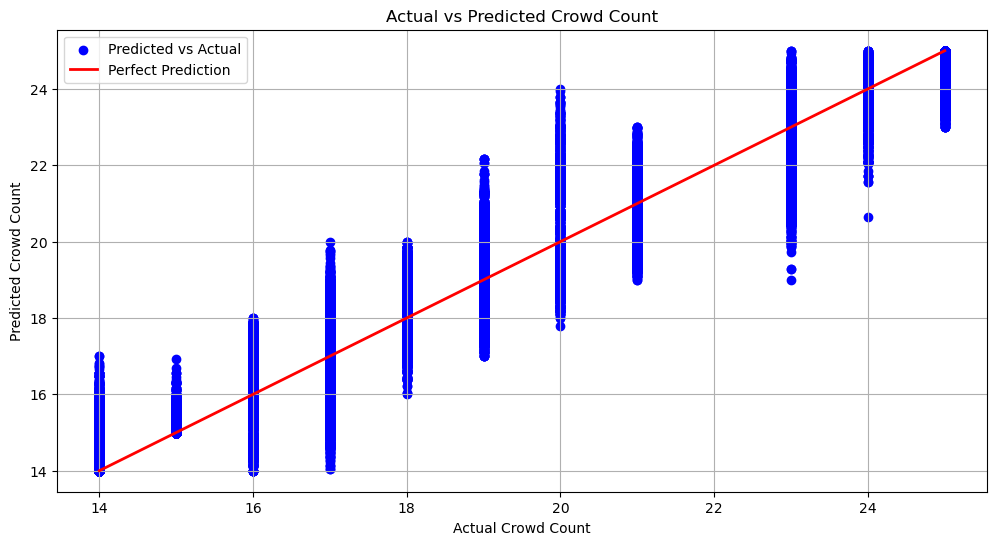

In [24]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Crowd Count')
plt.ylabel('Predicted Crowd Count')
plt.title('Actual vs Predicted Crowd Count')
plt.legend()
plt.grid(True)
plt.show()

### Insights

- Overall, most of the predicted values align reasonably well with the perfect prediction, suggesting the model has a decent level of accuracy.
- We can see that the model can predict the crowd size between 16 and 22 well.
- The model has no bias when predicting a count close to the true value.
- There is a presence of variance indicating the model's predictions are sometimes inconsistent. It could be overfitting to certain features or not capturing all patterns effectively

In [26]:
cnn_X = df.drop('crowd_count', axis=1).values
cnn_y = df['crowd_count'].values

scaler = StandardScaler()
cnn_X = scaler.fit_transform(cnn_X)

cnn_X = cnn_X.reshape(cnn_X.shape[0], cnn_X.shape[1], 1, 1)

X_train, X_test, y_train, y_test = train_test_split(cnn_X, cnn_y, test_size=0.2, random_state=42)

In [27]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 1), activation='relu', input_shape=(X_train.shape[1], 1, 1)),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=16, callbacks=[early_stop], verbose=1)

loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Absolute Error: {mae:.2f}")

cnn_y_pred = model.predict(X_test)

C:\Users\pinal\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
10221/10221 ━━━━━━━━━━━━━━━━━━━━ 70s 7ms/step - loss: 16.1164 - mae: 2.9306 - val_loss: 18.5418 - val_mae: 3.6203
Epoch 2/50
10221/10221 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step - loss: 7.8559 - mae: 2.2557 - val_loss: 16.8786 - val_mae: 3.4887
Epoch 3/50
10221/10221 ━━━━━━━━━━━━━━━━━━━━ 75s 7ms/step - loss: 6.3703 - mae: 2.0300 - val_loss: 10.7297 - val_mae: 2.7227
Epoch 4/50
10221/10221 ━━━━━━━━━━━━━━━━━━━━ 68s 7ms/step - loss: 5.4249 - mae: 1.8517 - val_loss: 16.4360 - val_mae: 3.5611
Epoch 5/50
10221/10221 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - loss: 5.1220 - mae: 1.7827 - val_loss: 16.1305 - val_mae: 3.5418
Epoch 6/50
10221/10221 ━━━━━━━━━━━━━━━━━━━━ 67s 7ms/step - loss: 4.8388 - mae: 1.7332 - val_loss: 13.1851 - val_mae: 3.1662
Epoch 7/50
10221/10221 ━━━━━━━━━━━━━━━━━━━━ 69s 7ms/step - loss: 4.5355 - mae: 1.6818 - val_loss: 8.2582 - val_mae: 2.4379
Epoch 8/50
10221/10221 ━━━━━━━━━━━━━━━━━━━━ 69s 7ms/step - loss: 4.4382 - mae: 1.6526 - val_loss: 7.6655 - val_mae: 2.3346
Epoch 9/5

In [28]:
cnn_mae = mean_absolute_error(y_test, cnn_y_pred)
cnn_mse = mean_squared_error(y_test, cnn_y_pred)
cnn_rmse = np.sqrt(cnn_mse)

print("\nCNN Performance:")
print(f"Mean Absolute Error (MAE): {cnn_mae:.2f}")
print(f"Mean Squared Error (MSE): {cnn_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {cnn_rmse:.2f}")


CNN Performance:
Mean Absolute Error (MAE): 1.05
Mean Squared Error (MSE): 1.84
Root Mean Squared Error (RMSE): 1.36


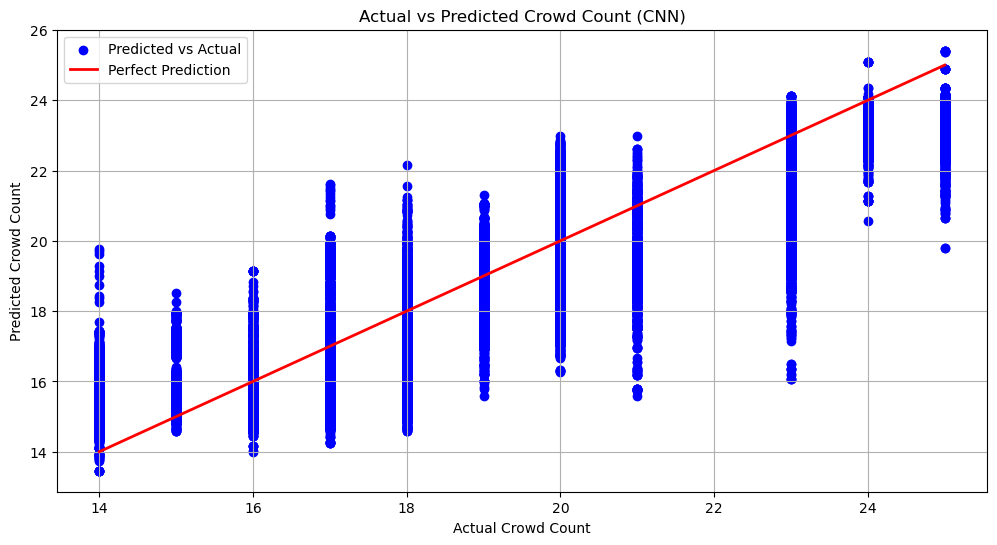

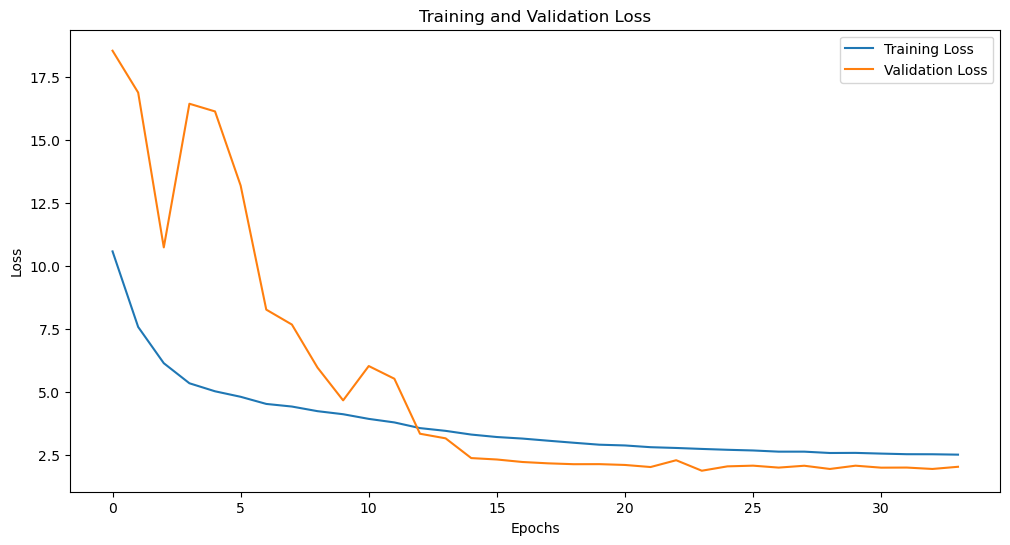

In [29]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, cnn_y_pred, color='blue', label='Predicted vs Actual')
plt.plot([cnn_y.min(), cnn_y.max()], [cnn_y.min(), cnn_y.max()], color='red', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Crowd Count')
plt.ylabel('Predicted Crowd Count')
plt.title('Actual vs Predicted Crowd Count (CNN)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()